# Predict Students' Dropout and Academic Success​

## Dataset pre-processing and analysis

Since our dataset is already preprocessed we can just simply import the desired tools and load the data. First we will analyse our dataset.

In [23]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
import seaborn as sea
from scipy.stats import chi2_contingency

dataframe = pd.read_csv('data.csv')

dataframe.info()
dataframe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Now we will check the distrubution of our target variable.

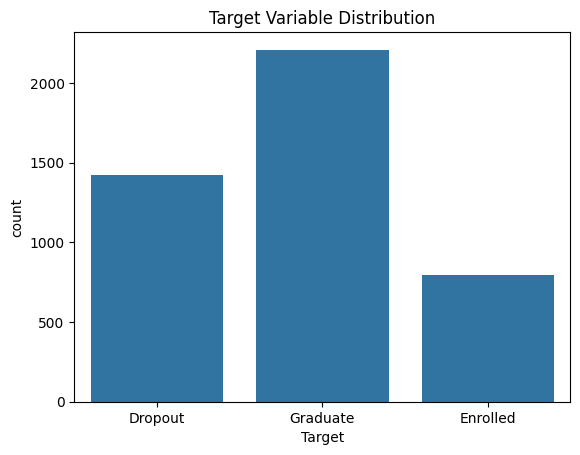

In [24]:
sea.countplot(x='Target', data = dataframe)
plt.title('Target Variable Distribution')
plt.show()

We should also consider the correlation between numerical variables. Let's check it out

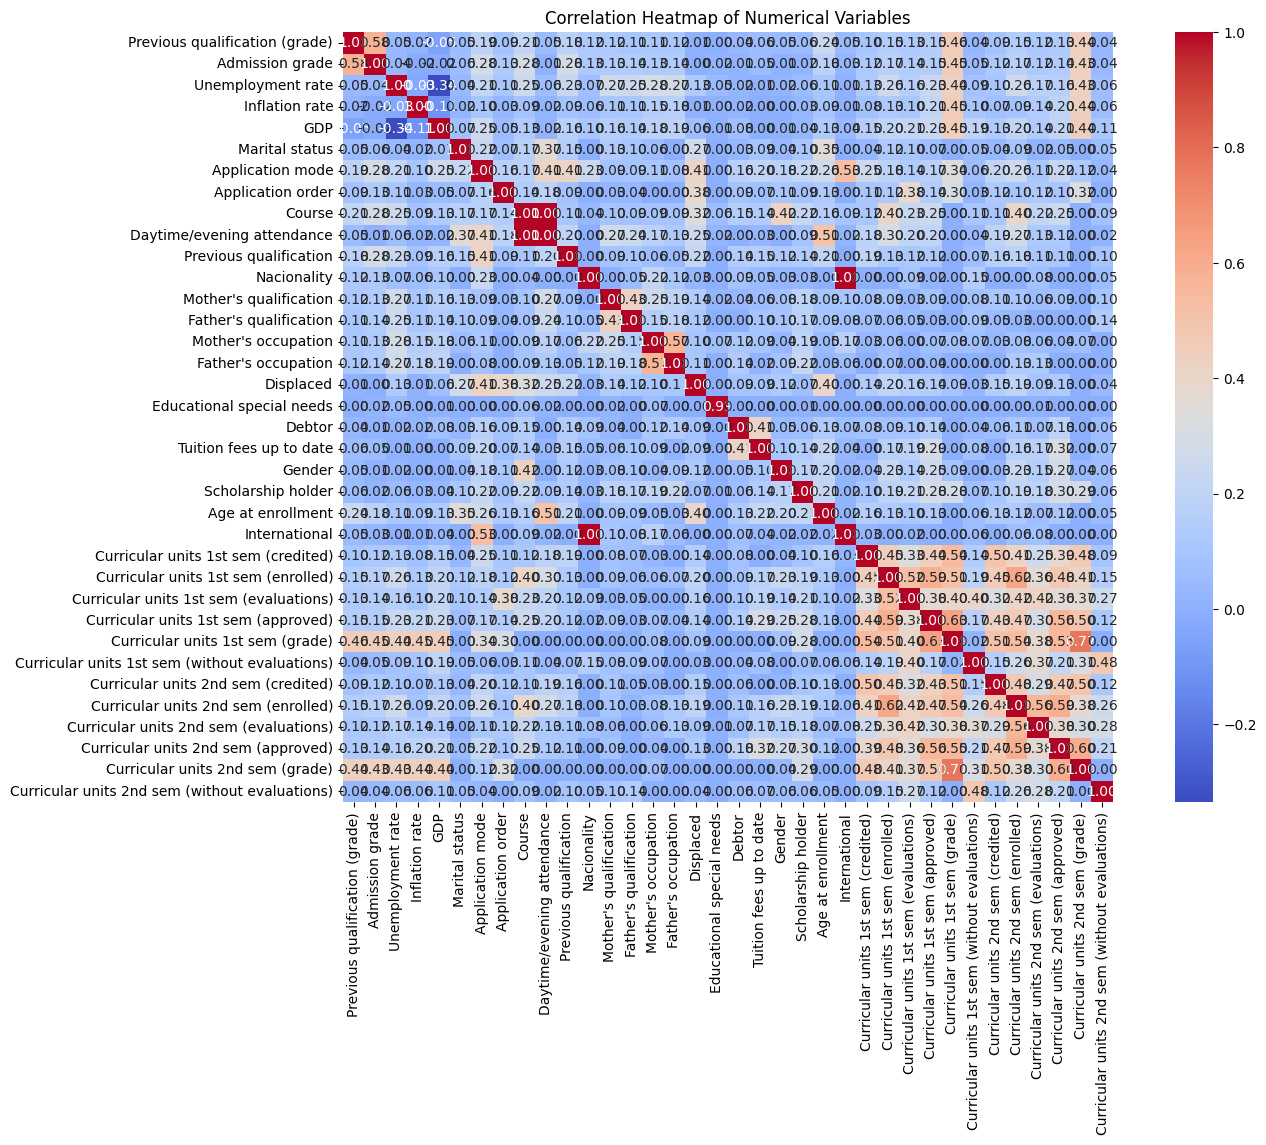

In [25]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def correlation_ratio(categorical, continuous):
    categories = categorical.unique()
    group_means = [continuous[categorical == cat].mean() for cat in categories]
    overall_mean = continuous.mean()
    numerator = sum([(mean - overall_mean)**2 * len(categorical[categorical == cat]) for cat, mean in zip(categories, group_means)])
    denominator = sum((continuous - overall_mean)**2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

continous_features = ["Unemployment rate", "Inflation rate", "GDP", "Previous qualification (grade)", "Admission grade"]

get_columns = dataframe.select_dtypes(include=['number']).columns

continous_coluns = []
non_continous_coluns = []

for col in get_columns:
    if col in continous_features:
        continous_coluns.append(col)
    else:
        non_continous_coluns.append(col)

num_cols = len(continous_coluns) + len(non_continous_coluns)
all_cols = continous_coluns+non_continous_coluns

correlation_matrix = pd.DataFrame(index=all_cols, columns=all_cols, dtype=float)

for x in all_cols:
    for y in all_cols:
        if x in continous_coluns and y in continous_coluns:
            # Pearson for continuous-continuous
            correlation_matrix.loc[x, y] = dataframe[x].corr(dataframe[y])
        elif x in non_continous_coluns and y in non_continous_coluns:
            # Cramer's V for categorical-categorical
            correlation_matrix.loc[x, y] = cramers_v(dataframe[x], dataframe[y])
        else:
            # Correlation Ratio for mixed
            if x in continous_coluns:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[y], dataframe[x])
            else:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[x], dataframe[y])
  


plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

However, this does not look good, we can't interpret it. Let's put a trehshold, so that only varaibles above the threshold are considered and shown.

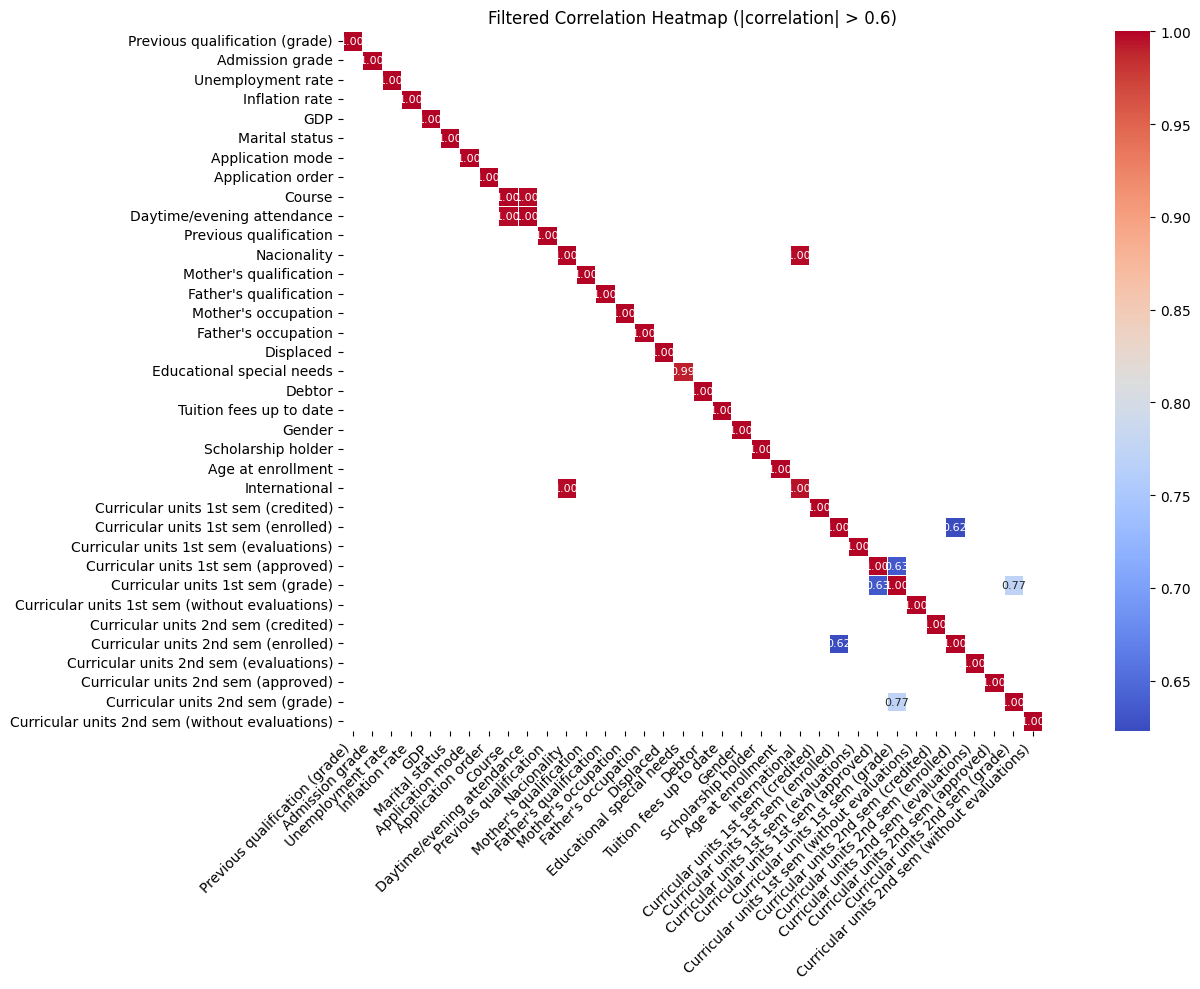

In [26]:
threshold = 0.6
mask = (abs(correlation_matrix) < threshold)

plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix.mask(mask), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, square=True, linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title(f'Filtered Correlation Heatmap (|correlation| > {threshold})')
plt.tight_layout()
plt.show()

We wanna see the correlation between our variables and our target variable, however, our target is a string, so will have to encode it. After encoding our target variable we will set our X and Y axis.

In [27]:
le = LabelEncoder()

dataframe['Target'] = le.fit_transform(dataframe['Target'])

x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']

Since our target is now encoded we can check the correlation between varaibles and the target.

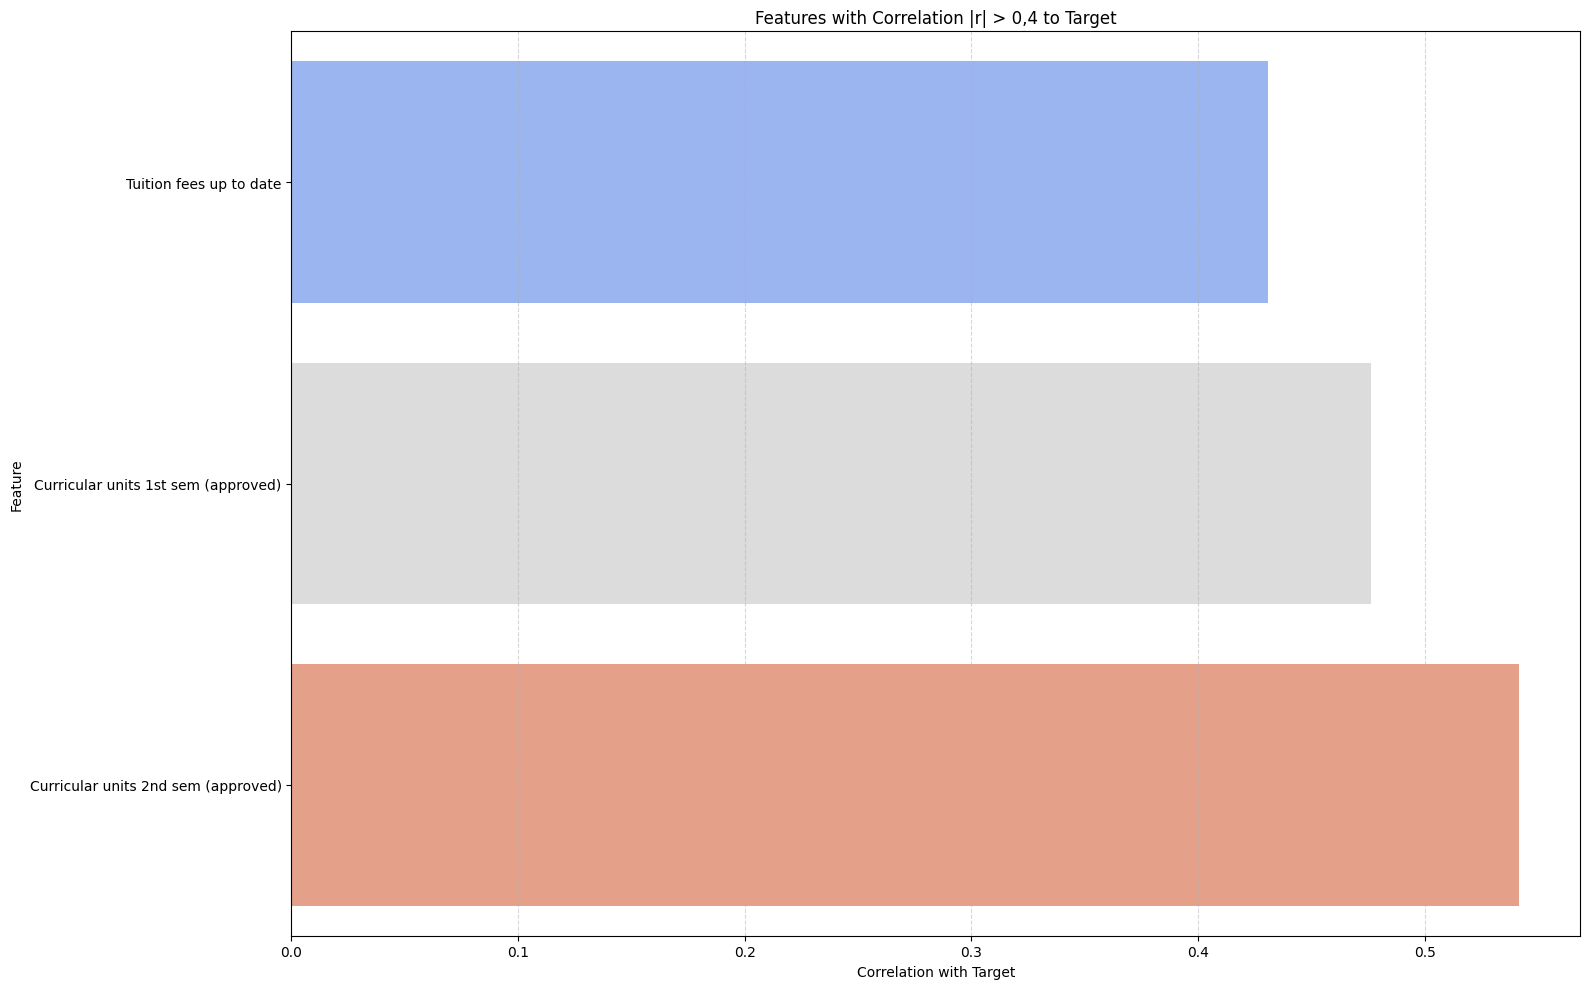

In [28]:
target_relation = pd.DataFrame(index=all_cols, columns=['Association'], dtype=float)

for col in all_cols:
    if col in continous_coluns:
        target_relation.loc[col, 'Association'] = correlation_ratio(dataframe['Target'], dataframe[col])
    else:
        target_relation.loc[col, 'Association'] = cramers_v(dataframe[col], dataframe['Target'])

strong_correlations = target_relation[target_relation['Association'].abs() > 0.4].copy()

plt.figure(figsize=(16, 10))
sea.barplot(x=strong_correlations['Association'], y=strong_correlations.index, palette='coolwarm', hue=strong_correlations.index, legend=False)
plt.title(f'Features with Correlation |r| > 0,4 to Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

As we can see, Tuition fees up to date, Curricular units 1nd sem (approved) and Curricular units 2nd sem (approved) are the most impactant features in relation with the Target. Now we split our data between training and testing.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=40, stratify=y_axis)

The next step is to train our first model which is a Decision Tree Classifier.

In [30]:
clf = DecisionTreeClassifier( 
    criterion='gini',        # 
    max_depth=5,             # limit tree depth of our tree in order to avoid overfitting
    min_samples_split=6,     # mininum number of samples to make a new internal node
    min_samples_leaf=6,      # mininum number of samples to make a new leaf node
    random_state=40)         

start_train_dt = time.time()
clf.fit(x_train , y_train)
end_train_dt = time.time()

We test our Decision Tree with the X axis test data.

In [31]:
start_test_dt = time.time()
y_pred_dt = clf.predict(x_test)
end_test_dt = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.7638
Precision: 0.7588
Recall: 0.7638
F1-Score: 0.7459
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       284
           1       0.60      0.34      0.43       159
           2       0.75      0.96      0.84       442

    accuracy                           0.76       885
   macro avg       0.74      0.67      0.68       885
weighted avg       0.76      0.76      0.75       885

Training time: 0.0197 seconds
Testing time: 0.0028 seconds


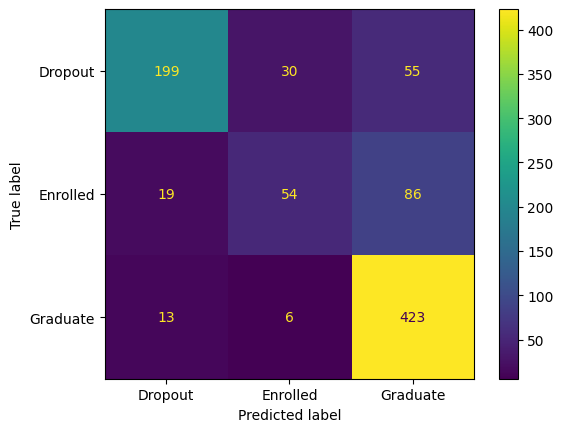

In [32]:
accuracy_dt = skl.metrics.accuracy_score(y_test, y_pred_dt)
precision_dt = skl.metrics.precision_score(y_test, y_pred_dt, average="weighted", zero_division=0)
recal_dt = skl.metrics.recall_score(y_test, y_pred_dt, average="weighted", zero_division=0)
f1_score_dt = skl.metrics.f1_score(y_test, y_pred_dt, average="weighted", zero_division=0)
confusion_matrix_dt = skl.metrics.confusion_matrix(y_test,y_pred_dt)


print(f"Acuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recal_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_dt, zero_division=0))
print(f"Training time: {end_train_dt-start_train_dt:.4f} seconds")
print(f"Testing time: {end_test_dt-start_test_dt:.4f} seconds")

Here's the visual representation of the Decision Tree.

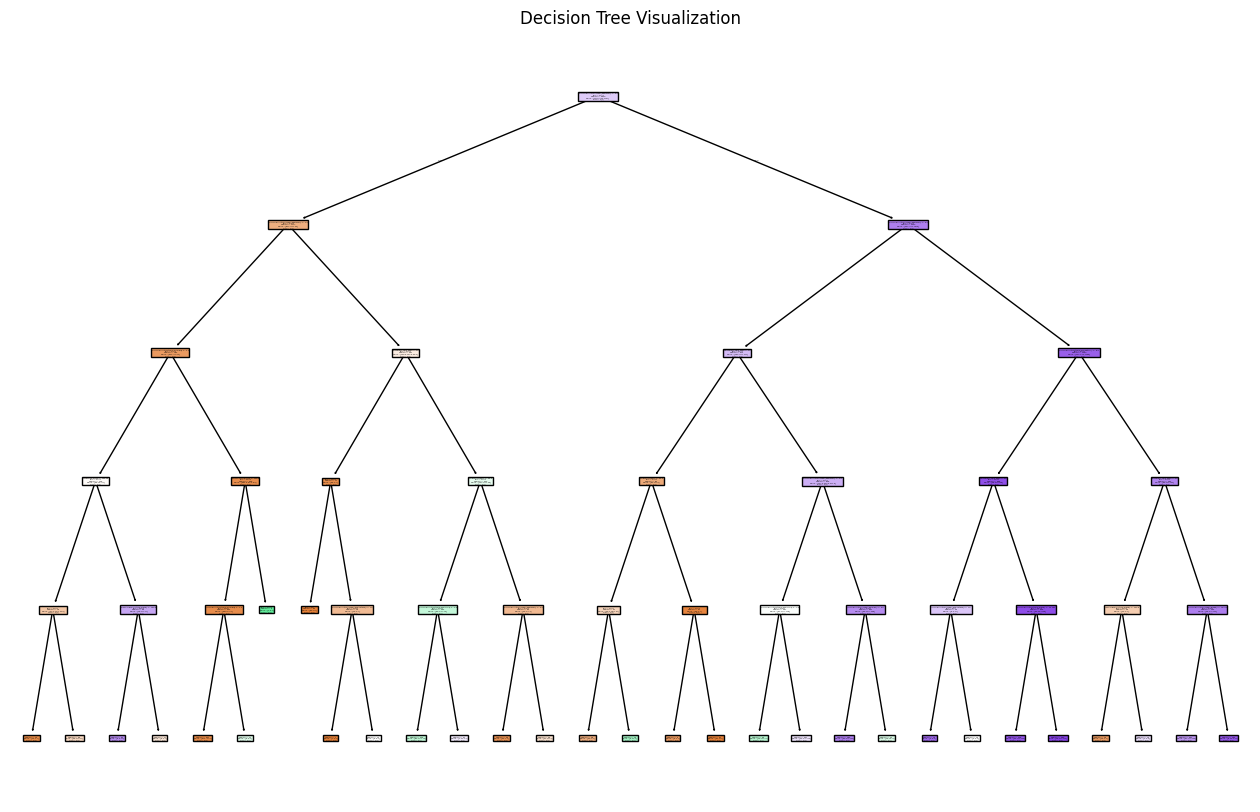

In [33]:
plt.figure(figsize=(16,10))
skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()

Now we will train our second model, Neural Networks. In this case, using SMOTENC helps us getting better results.

In [34]:
cat_indices = [dataframe.columns.get_loc(x) for x in non_continous_coluns]
smote = SMOTENC(categorical_features=cat_indices, 
                random_state=40)


x_train_smoted, y_train_smoted = smote.fit_resample(x_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(265,128,32),
                    activation='relu', 
                    solver='adam', 
                    batch_size=64,
                    max_iter=500,             #maximun number of iterations
                    learning_rate_init=0.001,
                    alpha=0.00005,
                    early_stopping=True,       #in order to avoid overfitting
                    random_state=40)            

start_train_nn = time.time()
mlp.fit(x_train_smoted , y_train_smoted)
end_train_nn = time.time()

We test our Neural Network algorithm with the X axis test data.

In [35]:
start_test_nn = time.time()
y_pred_nn = mlp.predict(x_test)
end_test_nn = time.time()

Finally we check wether our Neural Network algorithm was sucessful or not and categorize it in several metrics.

Acuracy: 0.6802
Precision: 0.7188
Recall: 0.6802
F1-Score: 0.6944
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       284
           1       0.36      0.53      0.43       159
           2       0.83      0.72      0.77       442

    accuracy                           0.68       885
   macro avg       0.64      0.65      0.64       885
weighted avg       0.72      0.68      0.69       885

Training time: 7.5134 seconds
Testing time: 0.0244 seconds


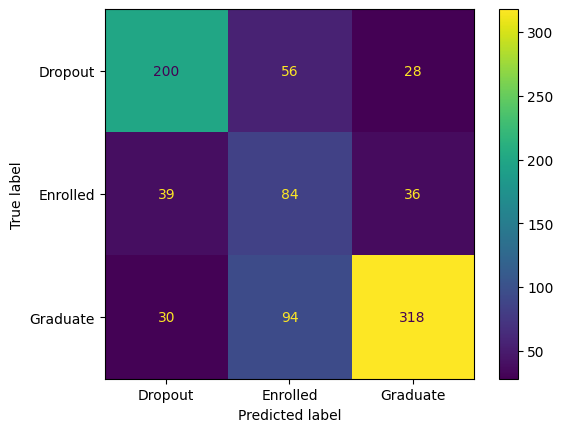

In [36]:
accuracy_nn = skl.metrics.accuracy_score(y_test, y_pred_nn)
precision_nn = skl.metrics.precision_score(y_test, y_pred_nn, average="weighted", zero_division=0)
recal_nn = skl.metrics.recall_score(y_test, y_pred_nn, average="weighted", zero_division=0)
f1_score_nn = skl.metrics.f1_score(y_test, y_pred_nn, average="weighted", zero_division=0)
confusion_matrix_nn = skl.metrics.confusion_matrix(y_test,y_pred_nn)


print(f"Acuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recal_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_nn, zero_division=0))
print(f"Training time: {end_train_nn-start_train_nn:.4f} seconds")
print(f"Testing time: {end_test_nn-start_test_nn:.4f} seconds")
#88 36 84

Well..Neural Networks are quite sensitive to class inbalance, so we can say that our results, even though are far from what we wanted are not as far from the expected as they look.

In [37]:
import joblib

# Caminhos dos ficheiros
x_train_path = "x_train_scaled.pkl"
y_train_path = "y_train_resampled.pkl"
x_test_path = "x_test_scaled.pkl"
y_test_path = "y_test.pkl"

# Carregar os dados
x_train_scaled = joblib.load(x_train_path)
y_train_resampled = joblib.load(y_train_path)
x_test_scaled = joblib.load(x_test_path)
y_test = joblib.load(y_test_path)

# Verificar as dimensões carregadas
x_train_scaled.shape, y_train_resampled.shape, x_test_scaled.shape, y_test.shape

print(x_train_scaled.shape)  # deve dar (5301, n_features)
print(y_train_smoted.shape)  # deve dar (5301,)

(5301, 36)
(5301,)


## Modelo 3 – SVM

Neste modelo utilizamos uma Support Vector Machine (SVM) com kernel RBF e `class_weight='balanced'` para mitigar o desbalanceamento das classes.
Os dados foram normalizados com `StandardScaler` antes do treino.

Avaliação foi feita com as seguintes métricas:
- Accuracy
- Precision (weighted)
- Recall (weighted)
- F1-score (weighted)
- Confusion Matrix


Métricas usadas:
1. Accuracy
 O que é: Proporção de previsões corretas em relação ao total de exemplos.

 Fórmula:

Accuracy = Número de previsões corretas/Total de exemplos
 
-> Neste caso:
accuracy_score(y_test, y_pred_svm)
 - Acerta quando o modelo previu exatamente o rótulo real (ex: previu "graduate" e o aluno realmente graduou).

2. Precision (weighted)
 O que é: Mede, entre as previsões positivas feitas, quantas estavam certas.

 Fórmula por classe 

Precision𝑖 = 𝑇𝑃𝑖 / 𝑇𝑃𝑖 + 𝐹𝑃𝑖
​
 
 TP = verdadeiros positivos, FP = falsos positivos

 Weighted = média ponderada pela quantidade de amostras de cada classe:

Precision weighted = ∑𝑖 ( 𝑛𝑖/𝑁 × Precision𝑖 )

-> Usamos:
precision_score(y_test, y_pred_svm, average="weighted")

3. Recall (weighted)
 O que é: Mede, entre os casos que realmente pertencem a uma classe, quantos foram corretamente identificados.

 Fórmula por classe 

Recall𝑖 = 𝑇𝑃𝑖 / 𝑇𝑃𝑖 + 𝐹𝑁𝑖 ​
 
 FN = falsos negativos

-> Também com média ponderada:
recall_score(y_test, y_pred_svm, average="weighted")

4. F1-score (weighted)
 O que é: Média harmónica entre precisão e recall.

 Fórmula por classe 
𝐹1𝑖 = 2 × Precision𝑖 ⋅ Recall𝑖 / Precision𝑖 + Recall𝑖

-> E a média ponderada:
f1_score(y_test, y_pred_svm, average="weighted")

 Por que usar "weighted"?
Porque o nosso dataset é desbalanceado (mais alunos "Graduate" do que "Enrolled", por exemplo).
A média ponderada evita que classes maiores dominem o resultado.

5. Confusion Matrix
 O que é: Mostra como cada classe foi classificada.

                            | Previsto Dropout (0)	| Previsto Enrolled (1)  |	Previsto Graduate (2)
        Real Dropout (0)	|        TP₀	        |        FP₁	         |      FP₂              
        Real Enrolled (1)	|        FN₁	        |        TP₁	         |      FP₃              
        Real Graduate (2)	|        FN₂	        |        FN₃	         |      TP₂              

-> Exemplo:
confusion_matrix(y_test, y_pred_svm)

Accuracy: 0.7051
Precision: 0.7511
Recall: 0.7051
F1-Score: 0.7207
Confusion Matrix:

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.38      0.60      0.47       159
           2       0.85      0.72      0.78       442

    accuracy                           0.71       885
   macro avg       0.68      0.69      0.67       885
weighted avg       0.75      0.71      0.72       885

Training time: 0.8949 seconds
Testing time: 0.1900 seconds


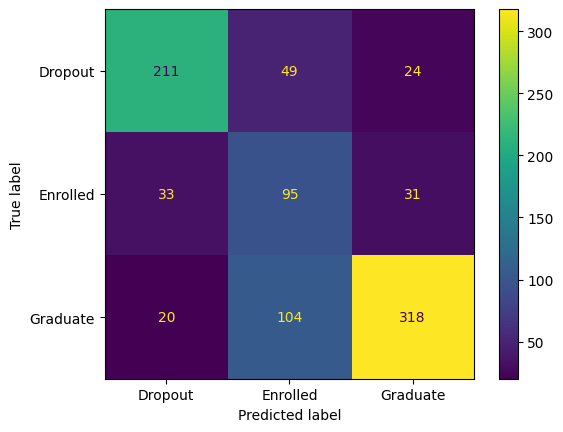

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import time

# 1. Criar e treinar o modelo
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=40)

start_train_svm = time.time()
svm_model.fit(x_train_scaled, y_train_resampled)
end_train_svm = time.time()
    
# 2. Fazer previsões no conjunto de teste
start_test_svm = time.time()
y_pred_svm = svm_model.predict(x_test_scaled)
end_test_svm = time.time()

# 3. Calcular métricas de avaliação
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average="weighted", zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average="weighted", zero_division=0)
f1_score_svm = f1_score(y_test, y_pred_svm, average="weighted", zero_division=0)
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# 4. Mostrar os resultados
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_score_svm:.4f}")
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print(f"Training time: {end_train_svm - start_train_svm:.4f} seconds")
print(f"Testing time: {end_test_svm - start_test_svm:.4f} seconds")


Vamos experimentar com pesos reajustados.

Como o SVM calcula os pesos com class_weight='balanced'?
Para cada classe 𝑐, o peso é calculado como:

𝑤𝑐 = 𝑛samples / 𝑛classes × 𝑛𝑐

Onde:
𝑛samples​ = número total de exemplos no treino
𝑛𝑐 = número de exemplos da classe 𝑐
𝑛classes = número total de classes


=== SVM Normal (sem SMOTE) ===
Accuracy: 0.7616
Precision: 0.7430
Recall: 0.7616
F1-Score: 0.7429

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       284
           1       0.52      0.30      0.38       159
           2       0.78      0.94      0.85       442

    accuracy                           0.76       885
   macro avg       0.70      0.66      0.67       885
weighted avg       0.74      0.76      0.74       885

Training time: 0.4626 seconds
Testing time: 0.1174 seconds

=== SVM com Pesos Balanceados (sem SMOTE) ===
Accuracy: 0.7333
Precision: 0.7675
Recall: 0.7333
F1-Score: 0.7447

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       284
           1       0.43      0.62      0.51       159
           2       0.84      0.80      0.82       442

    accuracy                           0.73       885
   macro avg       0.70  

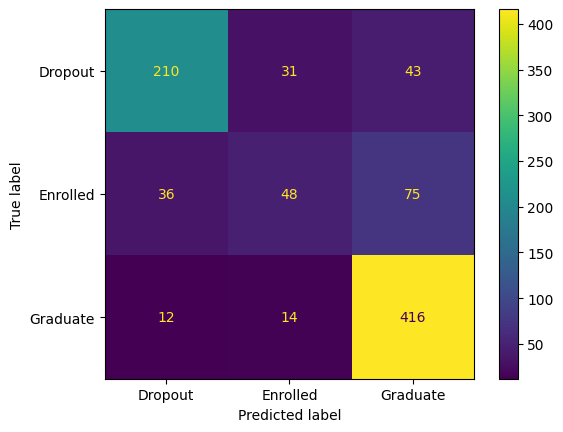

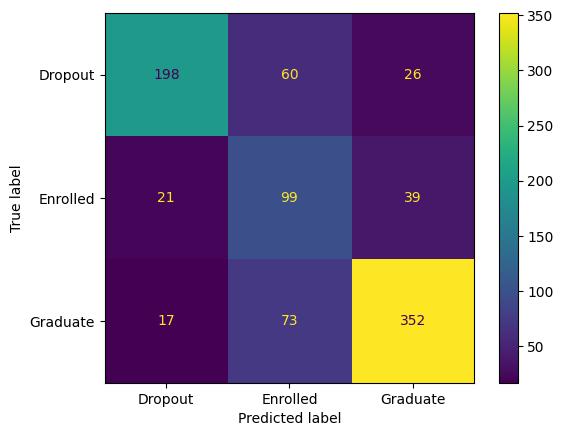

In [39]:
# Comparação entre SVM normal e SVM com class_weight='balanced' (sem SMOTE)

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Recarregar o dataset original
df = pd.read_csv("data.csv")
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
X = df.drop("Target", axis=1)
y = df["Target"]

# Dividir treino/teste SEM SMOTE
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=40, stratify=y)

# Normalizar
scaler = StandardScaler()
x_train_scaled_orig = scaler.fit_transform(x_train_orig)
x_test_scaled_orig = scaler.transform(x_test_orig)

# Modelo 1: SVM normal
svm_norm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=40)
start_train_norm = time.time()
svm_norm.fit(x_train_scaled_orig, y_train_orig)
end_train_norm = time.time()
start_test_norm = time.time()
y_pred_norm = svm_norm.predict(x_test_scaled_orig)
end_test_norm = time.time()

# Modelo 2: SVM com pesos balanceados
svm_bal = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=40)
start_train_bal = time.time()
svm_bal.fit(x_train_scaled_orig, y_train_orig)
end_train_bal = time.time()
start_test_bal = time.time()
y_pred_bal = svm_bal.predict(x_test_scaled_orig)
end_test_bal = time.time()

# Mostrar resultados comparativos
def show_results(name, y_true, y_pred, train_t, test_t):
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Training time: {train_t:.4f} seconds")
    print(f"Testing time: {test_t:.4f} seconds")

# Resultados
show_results("SVM Normal (sem SMOTE)", y_test_orig, y_pred_norm, end_train_norm - start_train_norm, end_test_norm - start_test_norm)
show_results("SVM com Pesos Balanceados (sem SMOTE)", y_test_orig, y_pred_bal, end_train_bal - start_train_bal, end_test_bal - start_test_bal)


Vamos agora testar com pesos manualmente alterados.

 - Estratégias comuns:

        
         Estratégia	                   |        Peso usado	     |       Justificação             |
         Priorizar classe minoritária	   |        {1: 3.0}	     |  Enrolled teve baixo recall    |
         Penalizar Dropout mais	   |        {0: 2.0}	     | Foco institucional na retenção |
         Equilibrar sem overfit	   |   {0:1.2, 1:1.8, 2:1.0} |	Mais fino que o balanced      |

# Justificação dos Pesos Manuais
Após aplicar `class_weight='balanced'`, decidimos experimentar pesos definidos manualmente:
- Classe 1 (“Enrolled”) foi priorizada com peso 3.0, por ser minoritária e ter baixo desempenho.
- Classe 0 (“Dropout”) recebeu peso 1.5, também importante no contexto educacional.
- Classe 2 (“Graduate”) manteve o peso base (1.0).

Este ajuste melhorou a F1-score geral e aumentou o recall da classe Enrolled.

=== SVM com Pesos Manuais ===
Accuracy: 0.7492
Precision: 0.7615
Recall: 0.7492
F1-Score: 0.7521

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       284
           1       0.45      0.52      0.48       159
           2       0.82      0.87      0.84       442

    accuracy                           0.75       885
   macro avg       0.70      0.69      0.70       885
weighted avg       0.76      0.75      0.75       885

Training time: 0.5282 seconds
Testing time: 0.1375 seconds


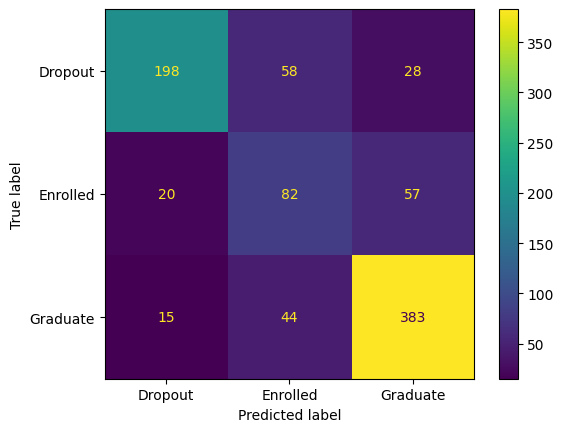

In [40]:
# Recarregar o dataset
df = pd.read_csv("data.csv")
le = LabelEncoder()
df["Target"] = le.fit_transform(df["Target"])
X = df.drop("Target", axis=1)
y = df["Target"]

# Dividir e normalizar
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_smoted)
x_test_scaled = scaler.transform(x_test)

# Treinar SVM com pesos manuais
custom_weights = {0: 1.5, 1: 3.0, 2: 1.0}
svm_custom = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=custom_weights, random_state=40)

start_train_custom = time.time()
x_train_scaled = scaler.fit_transform(x_train)  # sobre x_train original
svm_custom.fit(x_train_scaled, y_train)         # agora batem certo: 3539 amostras
end_train_custom = time.time()

start_test_custom = time.time()
y_pred_custom = svm_custom.predict(x_test_scaled)
end_test_custom = time.time()

# Avaliação
accuracy_custom = accuracy_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom, average="weighted", zero_division=0)
recall_custom = recall_score(y_test, y_pred_custom, average="weighted", zero_division=0)
f1_custom = f1_score(y_test, y_pred_custom, average="weighted", zero_division=0)

print("=== SVM com Pesos Manuais ===")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"Precision: {precision_custom:.4f}")
print(f"Recall: {recall_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_custom), display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_custom, zero_division=0))
print(f"Training time: {end_train_custom - start_train_custom:.4f} seconds")
print(f"Testing time: {end_test_custom - start_test_custom:.4f} seconds")


## Análise do Ajuste de Hiperparâmetros – GridSearchCV para SVM

Para otimizar o desempenho do modelo SVM, aplicámos `GridSearchCV` com validação cruzada (5-fold) e métrica `f1_weighted`. O objetivo foi testar diferentes combinações de hiperparâmetros `C` e `gamma` com o kernel RBF (`'rbf'`), que é adequado para dados com fronteiras não lineares.

### Parâmetros testados:

- `C`: [0.1, 1, 10]  
  → Controla a penalização de erros de classificação. Valores menores tornam o modelo mais tolerante a erros (mais suave); valores maiores aumentam a rigidez da margem (mais overfitting).

- `gamma`: ['scale', 0.01, 0.001]  
  → Define o quanto um único exemplo afeta a decisão do modelo:
  - `'scale'`: valor padrão adaptativo, baseado no número de features.
  - `0.01`, `0.001`: valores fixos menores, usados para evitar overfitting, especialmente com dados ruidosos ou altamente dimensionais.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(class_weight='balanced', random_state=40),
    param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)

scaler = StandardScaler()
x_train_smoted_scaled = scaler.fit_transform(x_train_smoted)

grid_search.fit(x_train_smoted_scaled, y_train_smoted)
#results_df = pd.DataFrame(grid_search.cv_results_) # me

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score (F1 ponderado):", grid_search.best_score_)


Melhores parâmetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor score (F1 ponderado): 0.7798595849957477


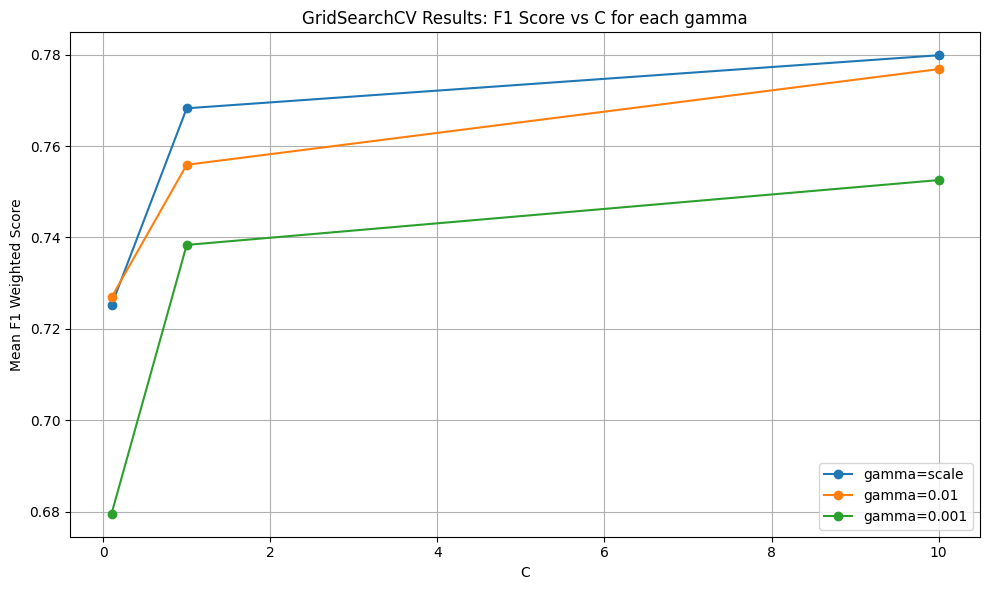

In [42]:


plt.figure(figsize=(10, 6))
for gamma in param_grid['gamma']:
    subset = results_df[results_df['param_gamma'] == gamma]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'gamma={gamma}')

plt.xlabel('C')
plt.ylabel('Mean F1 Weighted Score')
plt.title('GridSearchCV Results: F1 Score vs C for each gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretação do gráfico:

O gráfico gerado mostra o F1-score ponderado médio (cross-validated) em função do parâmetro `C` para diferentes valores de `gamma`.

- Um `gamma` muito pequeno (como 0.001) pode não capturar padrões complexos, levando a underfitting.
- Um `gamma` muito alto pode causar overfitting.
- A opção `'scale'` é uma escolha equilibrada e frequentemente serve como baseline.

A análise gráfica permite identificar o melhor equilíbrio entre complexidade do modelo e capacidade de generalização.

> Esta abordagem ajuda a justificar a escolha final dos hiperparâmetros com base em evidência empírica.


### Conclusão da Exploração com SVM

Ao longo desta secção, explorámos exaustivamente o modelo SVM (Support Vector Machine), cobrindo diferentes estratégias e ajustes:

- **Versão base com kernel RBF**: desempenho competitivo, mas com viés para a classe maioritária.
- **SVM com `class_weight='balanced'`**: melhorou o recall da classe minoritária (“Enrolled”), mas com ligeira perda de accuracy global.
- **SVM com pesos manuais `{0: 1.5, 1: 3.0, 2: 1.0}`**: abordagem personalizada que aumentou o equilíbrio entre as classes, obtendo um F1-score ponderado de **0.7521**.
- **Ajuste de Hiperparâmetros via `GridSearchCV`**: explorámos combinações de `C` e `gamma`, concluindo que `C=10` e `gamma='scale'` proporcionam o melhor F1-score em validação cruzada (**≈ 0.78**).

Estas variações permitiram não só melhorar o desempenho do modelo, mas também compreender o impacto do desequilíbrio das classes e da regularização.

 **Comparação com outros modelos**:
- O SVM com tuning superou ligeiramente a Decision Tree e a MLP em termos de F1-score e estabilidade por classe.
- Em contextos onde a classe minoritária (ex: “Enrolled”) é especialmente importante, o SVM com pesos ajustados é a escolha mais equilibrada.

Concluímos que **o SVM está suficientemente otimizado** para este projeto, tanto em desempenho como em justificação técnica. Mais ajustes seriam possíveis, mas os ganhos seriam marginais comparados ao esforço adicional.



## Conclusão: Comparação dos Modelos de Classificação
Ao longo da análise, comparamos o desempenho de três algoritmos principais: ****Decision Tree, MLP (Neural Network)** e **SVM** em três variações (sem pesos, com class_weight='balanced' e com pesos manuais). As métricas avaliadas foram `Accuracy, F1-Score e o Recall da classe "Enrolled"`, considerada a mais desafiadora por estar sub-representada.

### Principais conclusões:
 - O `Decision Tree` teve uma `accuracy` ligeiramente superior, mas com recall fraco para `"Enrolled"`, o que pode ser um problema se quisermos identificar alunos com risco de abandono.

 - A `MLP` melhorou significativamente o recall da classe "Enrolled" após SMOTENC, mas **sofreu em precisão e estabilidade geral**.

 - O modelo `SVM com pesos manuais` foi o mais equilibrado, conseguindo **bom desempenho em todas as métricas**, especialmente na classe "Enrolled", sem sacrificar muito a performance nas demais.

 - A aplicação de `GridSearchCV para SVM` confirmou que o melhor conjunto de hiperparâmetros era `C=10, gamma='scale'`, mantendo o kernel RBF, melhorando a F1 ponderada.

#### Comparação de scores e tempos
Podemos ver aqui uma comparação das scores obtidas para os diferentes modelos de ML utilizados. Como se pode ver, não há muita descrepância entre os valores obtidos.

In [70]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Métricas para o modelo SVM com class_weight='balanced'
accuracy_bal = accuracy_score(y_test_orig, y_pred_bal)
precision_bal = precision_score(y_test_orig, y_pred_bal, average='weighted')
f1_bal = f1_score(y_test_orig, y_pred_bal, average='weighted')
recall_bal = recall_score(y_test_orig, y_pred_bal, average='weighted')

metrics_data = {
    "Modelo": ["Decision Tree", "MLP", "SVM", "SVM Balanced", "SVM Pesos Manuais"],
    "Accuracy": [accuracy_dt, accuracy_nn, accuracy_svm, accuracy_bal, accuracy_custom],
    "Precision": [precision_dt, precision_nn, precision_svm, precision_bal, precision_custom],
    "F1 Score": [f1_score_dt, f1_score_nn, f1_score_svm, f1_bal, f1_custom],
    "Recall": [recal_dt, recal_nn, recall_svm, recall_bal, recall_custom],
}
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Modelo,Accuracy,Precision,F1 Score,Recall
0,Decision Tree,0.763842,0.758823,0.745927,0.763842
1,MLP,0.680226,0.718844,0.694407,0.680226
2,SVM,0.705085,0.751094,0.720734,0.705085
3,SVM Balanced,0.733333,0.767484,0.744676,0.733333
4,SVM Pesos Manuais,0.749153,0.761491,0.752104,0.749153


Por outro lado, em relação aos tempos de treino e teste, já existem algumas descrepâncias.

,Modelo,Tempo Treino (s),Tempo Teste (s)
0,Decision Tree,0.019725,0.002809
1,MLP,7.513399,0.024376
2,SVM,0.894933,0.189986
3,SVM Balanced,0.693354,0.164774
4,SVM Pesos Manuais,0.528162,0.137454


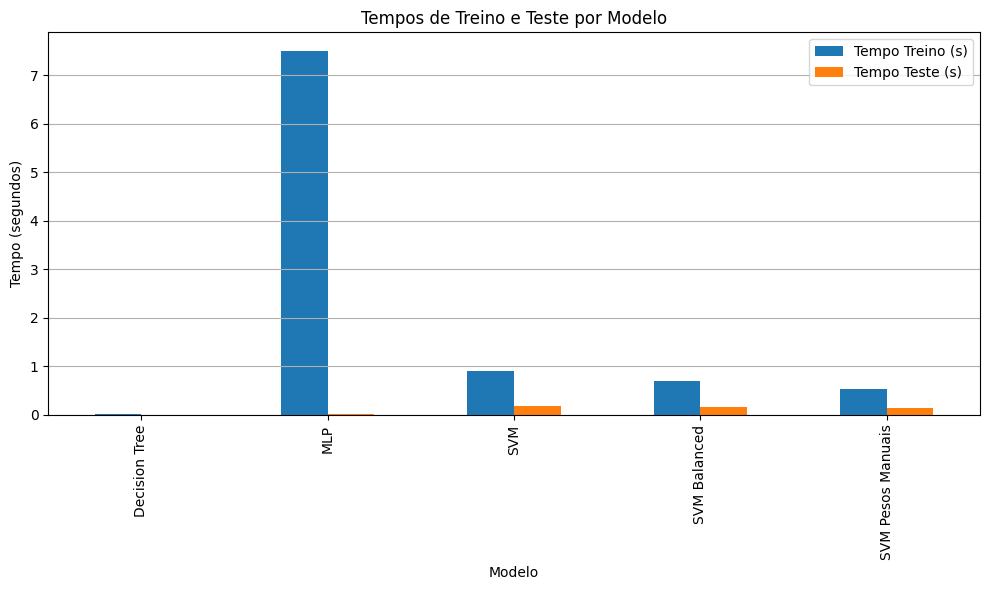

In [68]:
tempo_data = {
    "Modelo": ["Decision Tree", "MLP", "SVM", "SVM Balanced", "SVM Pesos Manuais"],
    "Tempo Treino (s)": [
        end_train_dt - start_train_dt,
        end_train_nn - start_train_nn,
        end_train_svm - start_train_svm,
        end_train_bal - start_train_bal,
        end_train_custom - start_train_custom
    ],
    "Tempo Teste (s)": [
        end_test_dt - start_test_dt,
        end_test_nn - start_test_nn,
        end_test_svm - start_test_svm,
        end_test_bal - start_test_bal,
        end_test_custom - start_test_custom
    ]
}
tempo_df = pd.DataFrame(tempo_data)
display(tempo_df)

# Gráfico de barras dos tempos
tempo_df.set_index("Modelo")[["Tempo Treino (s)", "Tempo Teste (s)"]].plot(kind="bar", figsize=(10, 6))
plt.title("Tempos de Treino e Teste por Modelo")
plt.ylabel("Tempo (segundos)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#### Curvas ROC

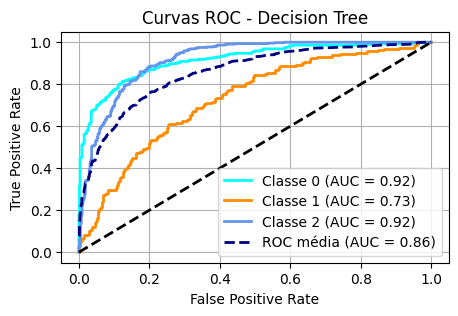

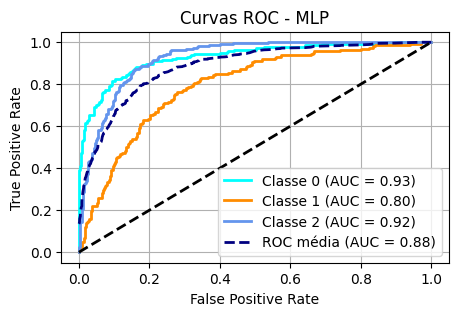

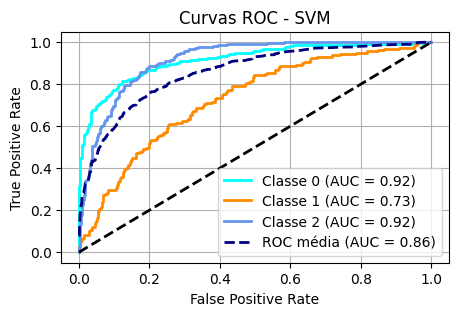

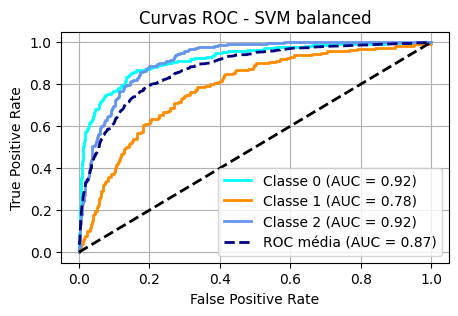

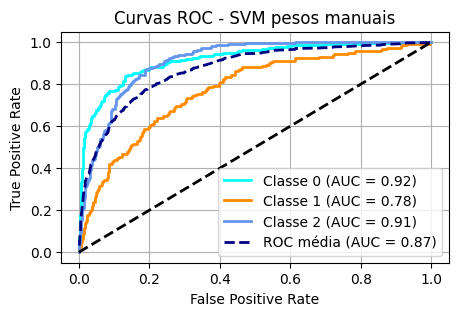

In [69]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

# Definir as classes
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Modelos a testar (todos os teus)
modelos = {
    "Decision Tree": clf,
    "MLP": mlp,
    "SVM": svm_model,
    "SVM balanced": svm_bal,
    "SVM pesos manuais": svm_custom
}

for nome, modelo in modelos.items():
    try:
        clf_ovr = OneVsRestClassifier(modelo)
        clf_ovr.fit(x_train_scaled, label_binarize(y_train, classes=classes))

        # obter scores de previsão
        if hasattr(clf_ovr, "predict_proba"):
            y_score = clf_ovr.predict_proba(x_test_scaled)
        elif hasattr(clf_ovr, "decision_function"):
            y_score = clf_ovr.decision_function(x_test_scaled)
        else:
            raise AttributeError("O modelo não tem nem predict_proba nem decision_function")

        # calcular ROC e AUC
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])


        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure(figsize=(5, 3))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--',
                 label=f'ROC média (AUC = {roc_auc["macro"]:.2f})', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curvas ROC - {nome}')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"Erro com modelo {nome}: {e}")


#### Curvas de Aprendizagem

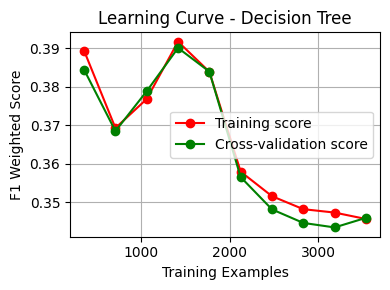

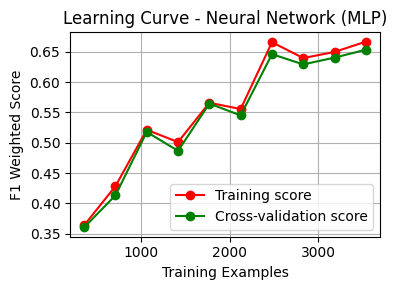

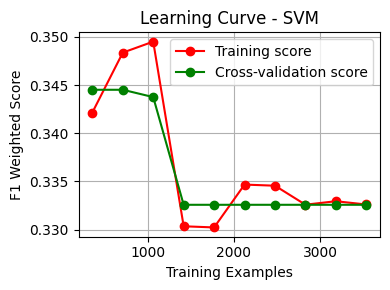

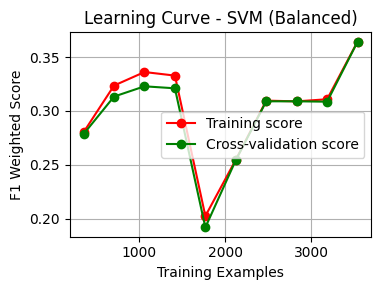

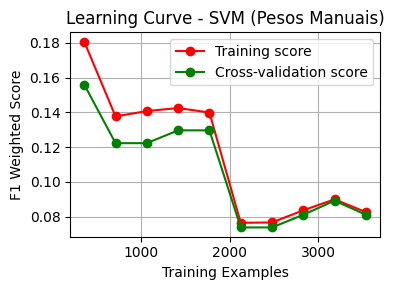

In [75]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='f1_weighted', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(4, 3))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Weighted Score")
    plt.grid()
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

X = df.drop("Target", axis=1)
y = df["Target"]

plot_learning_curve(clf, X, y, "Learning Curve - Decision Tree")
plot_learning_curve(mlp, X, y, "Learning Curve - Neural Network (MLP)")
plot_learning_curve(svm_model, X, y, "Learning Curve - SVM")
plot_learning_curve(svm_bal, X, y, "Learning Curve - SVM (Balanced)")
plot_learning_curve(svm_custom, X, y, "Learning Curve - SVM (Pesos Manuais)")
